# DTSA-5511: Week 5 Mini- Project
## Brief description of the problem and data

This project is based on Kaggle competition ["I’m Something of a Painter Myself"](https://www.kaggle.com/competitions/gan-getting-started),  I will make use of Generative Adversarial Networks (GANs) to replicate the distinctive artistic style of Claude Monet. GANs consist of generator and discriminator neural networks, working in tandem yet with opposing goals. The generator strives to create images, in this case in the style of Monet.

This competition challenges participants to construct a GAN capable of producing 7,000 to 10,000 images mirroring Monet’s unique artistic essence, exploring the potential of data science in mimicking intricate artistic styles traditionally perceived as solely human endeavors.

In [48]:
import sys
import platform
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import os
import warnings

import PIL
import shutil

import tensorflow as tf
import tensorflow_addons as tfa

from tensorflow import keras
from tensorflow.keras import layers
import shutil

warnings.simplefilter(action = 'ignore', category = FutureWarning)
warnings.simplefilter(action = 'ignore', category = Warning)

In [8]:
sys.version

'3.11.5 (main, Sep 11 2023, 13:54:46) [GCC 11.2.0]'

In [9]:
tf.__version__

'2.15.0'

In [10]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [13]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
    if tf.test.is_gpu_available():
        print("GPU is available.")
        !nvidia-smi
    else:
        print("Training on CPU.")

print('Number of replicas:', strategy.num_replicas_in_sync)

AUTOTUNE = tf.data.experimental.AUTOTUNE

GPU is available.
Tue Feb  6 18:55:08 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.40.06              Driver Version: 551.23         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3070 ...    On  |   00000000:01:00.0  On |                  N/A |
| N/A   45C    P8             13W /  115W |     426MiB /   8192MiB |     11%      Default |
|                                         |                        |                  N/A |
+-----------------------------

2024-02-06 18:55:08.831443: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-06 18:55:08.831616: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-06 18:55:08.831660: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-06 18:55:08.832029: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-06 18:55:08.832045: I tensorflow/core/common_runtime/gpu/gpu

Unfortunately I can't fix the errors. After some googling, I figured that it is a common error when running WSL 2. If you know how to fix it, please tell me.

# Exploratory Data Analysis(EDA) - Inspect, Visualize and Clean the Data

I would now start inspecting our dataset

In [14]:
os.listdir(".")

['.git',
 'README.md',
 'monet_tfrec',
 'photo_jpg',
 'photo_tfrec',
 'monet_jpg',
 '.gitignore',
 'CycleGAN.ipynb',
 '.ipynb_checkpoints']

In [16]:
MONET_FILENAMES = tf.io.gfile.glob(str('./monet_tfrec/*.tfrec'))
print('Monet TFRecord Files:', len(MONET_FILENAMES))

PHOTO_FILENAMES = tf.io.gfile.glob(str('./photo_tfrec/*.tfrec'))
print('Photo TFRecord Files:', len(PHOTO_FILENAMES))

Monet TFRecord Files: 5
Photo TFRecord Files: 20


In [17]:
IMAGE_SIZE = [256, 256]

def decode_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = (tf.cast(image, tf.float32) / 127.5) - 1
    image = tf.reshape(image, [*IMAGE_SIZE, 3])
    return image

def read_tfrecord(example):
    tfrecord_format = {
        "image_name": tf.io.FixedLenFeature([], tf.string),
        "image": tf.io.FixedLenFeature([], tf.string),
        "target": tf.io.FixedLenFeature([], tf.string)
    }
    example = tf.io.parse_single_example(example, tfrecord_format)
    image = decode_image(example['image'])
    return image

In [18]:
def load_dataset(filenames, labeled=True, ordered=False):
    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.map(read_tfrecord, num_parallel_calls=AUTOTUNE)
    return dataset

In [19]:
monet_ds = load_dataset(MONET_FILENAMES, labeled=True).batch(1)
photo_ds = load_dataset(PHOTO_FILENAMES, labeled=True).batch(1)

2024-02-06 19:08:20.782727: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-06 19:08:20.782924: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-06 19:08:20.782966: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-06 19:08:20.783406: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-06 19:08:20.783423: I tensorflow/core/common_runtime/gpu/gpu

In [23]:
def count_items_in_dataset(dataset):
    count = 0
    for _ in dataset:
        count += 1
    return count

print(f"Number of Monet images: {count_items_in_dataset(monet_ds)}")
print(f"Number of Photo images: {count_items_in_dataset(photo_ds)}")

Number of Monet images: 300
Number of Photo images: 7038


In [24]:
def display_samples(ds, title, samples = 5):
    plt.figure(figsize = (20, 8))
    for i, img in enumerate(ds.take(samples)):
        plt.subplot(1, samples, i + 1)
        plt.title(f'{title} {i + 1}')
        plt.imshow(img[0] * 0.5 + 0.5)
        plt.axis('off')
    plt.show()

Let us check some of the first pictures

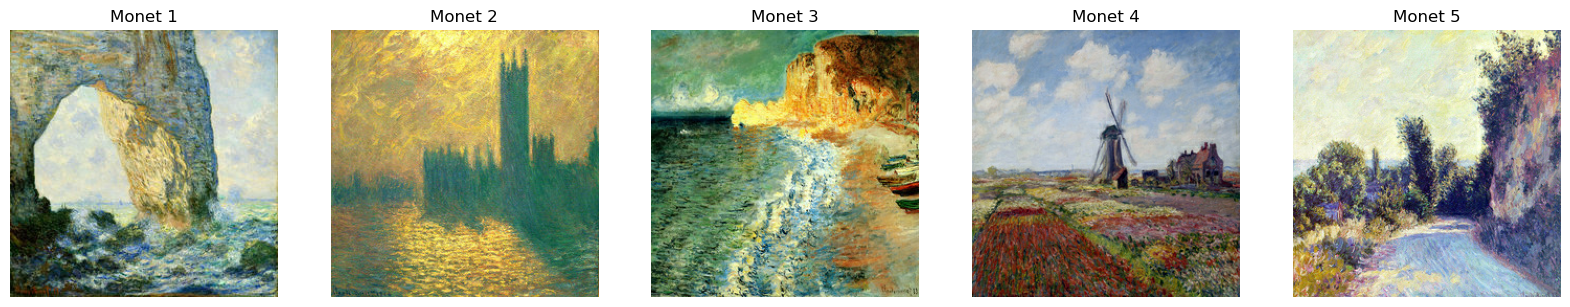

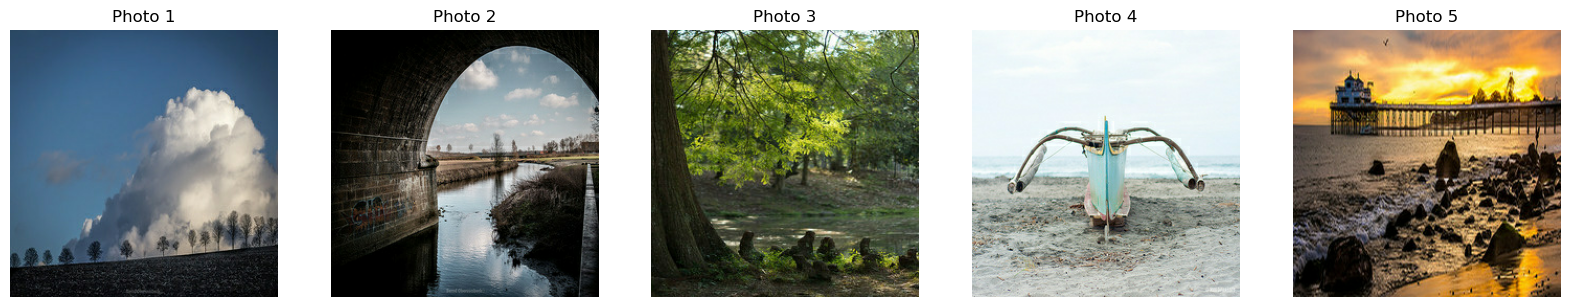

In [25]:
display_samples(monet_ds, 'Monet')
display_samples(photo_ds, 'Photo')

The dataset provides 300 Monet images and 7,038 photo images. It is distinctive that Monet paintings exhibit quite strong characteristics when compared to photos. Next, we will create and train a model to generate Monet-like photos, detailing how we achieve the objective.

# Model Architecture
## Model selection
There are several GAN models available, GAN, CycleGAN, Pix2Pix, StyleGAN, StarGAN and others. For this project, we have chosen to implement the CycleGAN while some of models required paired training samples.
### CycleGAN
CycleGAN is a deep CNN approach for learning for image-to-image translation, enabling the transformation of images from one domain to another without paired training examples. It utilizes a cycle-consistency loss to ensure that the translation is coherent and can be reverted back to the original image.

It can learn to translate between two image domains without paired training data, which is a significant advantage in real-world scenarios where obtaining such pairs is often unfeasible.
#### Building the generator(UNET architecture)
We would reduce the 2D dimensions of the image, using Conv2D layers, Instance Normalization, and LeakyReLU activation.

In [26]:
OUTPUT_CHANNELS = 3

def downsample(filters, size, apply_instancenorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    result = keras.Sequential()
    result.add(layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

    if apply_instancenorm:
        result.add(tfa.layers.InstanceNormalization(gamma_initializer=gamma_init))

    result.add(layers.LeakyReLU())

    return result

We would also increases the 2D dimensions of the image using Conv2DTranspose layers, Instance Normalization, and ReLU activation.

In [27]:
def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    result = keras.Sequential()
    result.add(layers.Conv2DTranspose(filters, size, strides=2,
                                      padding='same',
                                      kernel_initializer=initializer,
                                      use_bias=False))

    result.add(tfa.layers.InstanceNormalization(gamma_initializer=gamma_init))

    if apply_dropout:
        result.add(layers.Dropout(0.5))

    result.add(layers.ReLU())

    return result

Concatenates the output of downsample layers to upsample layers symmetrically to bypass the vanishing gradient problem and outputs an image into the target domain.

In [28]:
def Generator():
    inputs = layers.Input(shape=[256,256,3])

    # bs = batch size
    down_stack = [
        downsample(64, 4, apply_instancenorm=False), # (bs, 128, 128, 64)
        downsample(128, 4), # (bs, 64, 64, 128)
        downsample(256, 4), # (bs, 32, 32, 256)
        downsample(512, 4), # (bs, 16, 16, 512)
        downsample(512, 4), # (bs, 8, 8, 512)
        downsample(512, 4), # (bs, 4, 4, 512)
        downsample(512, 4), # (bs, 2, 2, 512)
        downsample(512, 4), # (bs, 1, 1, 512)
    ]

    up_stack = [
        upsample(512, 4, apply_dropout=True), # (bs, 2, 2, 1024)
        upsample(512, 4, apply_dropout=True), # (bs, 4, 4, 1024)
        upsample(512, 4, apply_dropout=True), # (bs, 8, 8, 1024)
        upsample(512, 4), # (bs, 16, 16, 1024)
        upsample(256, 4), # (bs, 32, 32, 512)
        upsample(128, 4), # (bs, 64, 64, 256)
        upsample(64, 4), # (bs, 128, 128, 128)
    ]

    initializer = tf.random_normal_initializer(0., 0.02)
    last = layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                  strides=2,
                                  padding='same',
                                  kernel_initializer=initializer,
                                  activation='tanh') # (bs, 256, 256, 3)

    x = inputs

    # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = layers.Concatenate()([x, skip])

    x = last(x)

    return keras.Model(inputs=inputs, outputs=x)

2D image where higher pixel values indicate real classifications and lower values indicate fake classifications.

In [29]:
def Discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    inp = layers.Input(shape=[256, 256, 3], name='input_image')

    x = inp

    down1 = downsample(64, 4, False)(x) # (bs, 128, 128, 64)
    down2 = downsample(128, 4)(down1) # (bs, 64, 64, 128)
    down3 = downsample(256, 4)(down2) # (bs, 32, 32, 256)

    zero_pad1 = layers.ZeroPadding2D()(down3) # (bs, 34, 34, 256)
    conv = layers.Conv2D(512, 4, strides=1,
                         kernel_initializer=initializer,
                         use_bias=False)(zero_pad1) # (bs, 31, 31, 512)

    norm1 = tfa.layers.InstanceNormalization(gamma_initializer=gamma_init)(conv)

    leaky_relu = layers.LeakyReLU()(norm1)

    zero_pad2 = layers.ZeroPadding2D()(leaky_relu) # (bs, 33, 33, 512)

    last = layers.Conv2D(1, 4, strides=1,
                         kernel_initializer=initializer)(zero_pad2) # (bs, 30, 30, 1)

    return tf.keras.Model(inputs=inp, outputs=last)

In [30]:
with strategy.scope():
    monet_generator = Generator() # transforms photos to Monet-esque paintings
    photo_generator = Generator() # transforms Monet paintings to be more like photos

    monet_discriminator = Discriminator() # differentiates real Monet paintings and generated Monet paintings
    photo_discriminator = Discriminator() # differentiates real photos and generated photos

#### Building the CycleGAN model

In [31]:
class CycleGan(keras.Model):
    def __init__(
        self,
        monet_generator,
        photo_generator,
        monet_discriminator,
        photo_discriminator,
        lambda_cycle=10,
    ):
        super(CycleGan, self).__init__()
        self.m_gen = monet_generator
        self.p_gen = photo_generator
        self.m_disc = monet_discriminator
        self.p_disc = photo_discriminator
        self.lambda_cycle = lambda_cycle
        
    def compile(
        self,
        m_gen_optimizer,
        p_gen_optimizer,
        m_disc_optimizer,
        p_disc_optimizer,
        gen_loss_fn,
        disc_loss_fn,
        cycle_loss_fn,
        identity_loss_fn
    ):
        super(CycleGan, self).compile()
        self.m_gen_optimizer = m_gen_optimizer
        self.p_gen_optimizer = p_gen_optimizer
        self.m_disc_optimizer = m_disc_optimizer
        self.p_disc_optimizer = p_disc_optimizer
        self.gen_loss_fn = gen_loss_fn
        self.disc_loss_fn = disc_loss_fn
        self.cycle_loss_fn = cycle_loss_fn
        self.identity_loss_fn = identity_loss_fn
        
    def train_step(self, batch_data):
        real_monet, real_photo = batch_data
        
        with tf.GradientTape(persistent=True) as tape:
            # photo to monet back to photo
            fake_monet = self.m_gen(real_photo, training=True)
            cycled_photo = self.p_gen(fake_monet, training=True)

            # monet to photo back to monet
            fake_photo = self.p_gen(real_monet, training=True)
            cycled_monet = self.m_gen(fake_photo, training=True)

            # generating itself
            same_monet = self.m_gen(real_monet, training=True)
            same_photo = self.p_gen(real_photo, training=True)

            # discriminator used to check, inputing real images
            disc_real_monet = self.m_disc(real_monet, training=True)
            disc_real_photo = self.p_disc(real_photo, training=True)

            # discriminator used to check, inputing fake images
            disc_fake_monet = self.m_disc(fake_monet, training=True)
            disc_fake_photo = self.p_disc(fake_photo, training=True)

            # evaluates generator loss
            monet_gen_loss = self.gen_loss_fn(disc_fake_monet)
            photo_gen_loss = self.gen_loss_fn(disc_fake_photo)

            # evaluates total cycle consistency loss
            total_cycle_loss = self.cycle_loss_fn(real_monet, cycled_monet, self.lambda_cycle) + self.cycle_loss_fn(real_photo, cycled_photo, self.lambda_cycle)

            # evaluates total generator loss
            total_monet_gen_loss = monet_gen_loss + total_cycle_loss + self.identity_loss_fn(real_monet, same_monet, self.lambda_cycle)
            total_photo_gen_loss = photo_gen_loss + total_cycle_loss + self.identity_loss_fn(real_photo, same_photo, self.lambda_cycle)

            # evaluates discriminator loss
            monet_disc_loss = self.disc_loss_fn(disc_real_monet, disc_fake_monet)
            photo_disc_loss = self.disc_loss_fn(disc_real_photo, disc_fake_photo)

        # Calculate the gradients for generator and discriminator
        monet_generator_gradients = tape.gradient(total_monet_gen_loss,
                                                  self.m_gen.trainable_variables)
        photo_generator_gradients = tape.gradient(total_photo_gen_loss,
                                                  self.p_gen.trainable_variables)

        monet_discriminator_gradients = tape.gradient(monet_disc_loss,
                                                      self.m_disc.trainable_variables)
        photo_discriminator_gradients = tape.gradient(photo_disc_loss,
                                                      self.p_disc.trainable_variables)

        # Apply the gradients to the optimizer
        self.m_gen_optimizer.apply_gradients(zip(monet_generator_gradients,
                                                 self.m_gen.trainable_variables))

        self.p_gen_optimizer.apply_gradients(zip(photo_generator_gradients,
                                                 self.p_gen.trainable_variables))

        self.m_disc_optimizer.apply_gradients(zip(monet_discriminator_gradients,
                                                  self.m_disc.trainable_variables))

        self.p_disc_optimizer.apply_gradients(zip(photo_discriminator_gradients,
                                                  self.p_disc.trainable_variables))
        
        return {
            "monet_gen_loss": total_monet_gen_loss,
            "photo_gen_loss": total_photo_gen_loss,
            "monet_disc_loss": monet_disc_loss,
            "photo_disc_loss": photo_disc_loss
        }

#### Defining the loss functions

In [32]:
with strategy.scope():
    def discriminator_loss(real, generated):
        real_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(real), real)

        generated_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.zeros_like(generated), generated)

        total_disc_loss = real_loss + generated_loss

        return total_disc_loss * 0.5

In [33]:
with strategy.scope():
    def generator_loss(generated):
        return tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(generated), generated)

In [34]:
with strategy.scope():
    def calc_cycle_loss(real_image, cycled_image, LAMBDA):
        loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))

        return LAMBDA * loss1

In [35]:
with strategy.scope():
    def identity_loss(real_image, same_image, LAMBDA):
        loss = tf.reduce_mean(tf.abs(real_image - same_image))
        return LAMBDA * 0.5 * loss

#### Train the CycleGAN

In [36]:
with strategy.scope():
    monet_generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    photo_generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

    monet_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    photo_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

#### Train the model (Epoch = 50)

In [49]:
with strategy.scope():
    cycle_gan_model_50 = CycleGan(
        monet_generator, photo_generator, monet_discriminator, photo_discriminator
    )

    cycle_gan_model_50.compile(
        m_gen_optimizer = monet_generator_optimizer,
        p_gen_optimizer = photo_generator_optimizer,
        m_disc_optimizer = monet_discriminator_optimizer,
        p_disc_optimizer = photo_discriminator_optimizer,
        gen_loss_fn = generator_loss,
        disc_loss_fn = discriminator_loss,
        cycle_loss_fn = calc_cycle_loss,
        identity_loss_fn = identity_loss
    )

In [52]:
cycle_gan_model_50.fit(
    tf.data.Dataset.zip((monet_ds, photo_ds)),
    epochs=50,
)

SyntaxError: positional argument follows keyword argument (1102813548.py, line 5)

In [53]:
def plot_image():
    _, ax = plt.subplots(5, 2, figsize=(12, 12))
    for i, img in enumerate(photo_ds.take(5)):
        prediction = monet_generator(img, training=False)[0].numpy()
        prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
        img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)

        ax[i, 0].imshow(img)
        ax[i, 1].imshow(prediction)
        ax[i, 0].set_title("Input Photo")
        ax[i, 1].set_title("Monet-esque")
        ax[i, 0].axis("off")
        ax[i, 1].axis("off")
    plt.show()

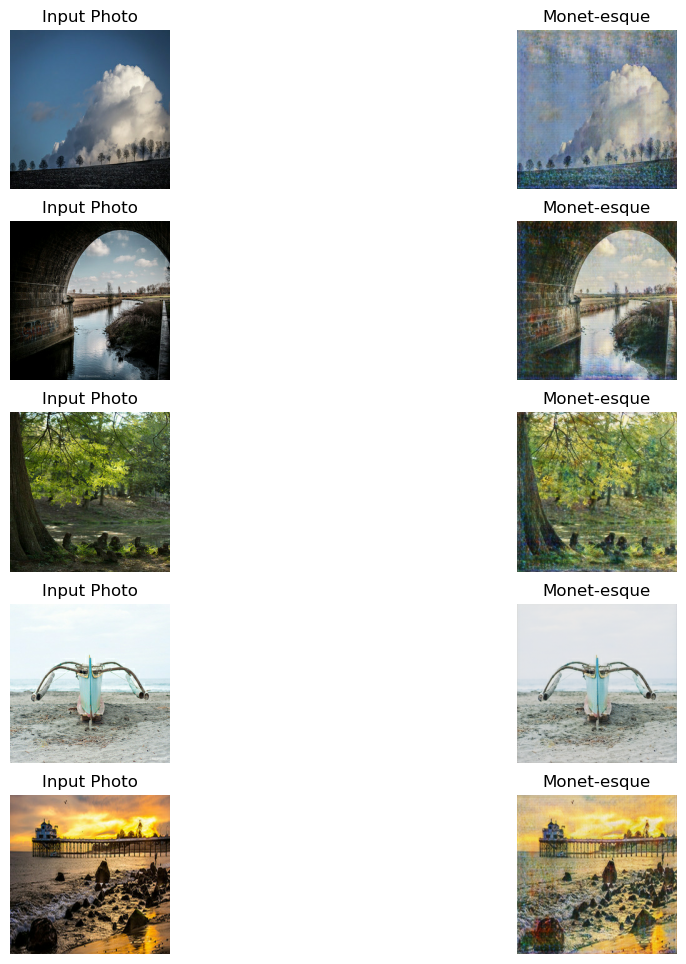

In [54]:
plot_image()

In [55]:
def generate_images(image_path):
    
    i = 1
    for img in photo_ds:
        prediction = monet_generator(img, training=False)[0].numpy()
        prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
        im = PIL.Image.fromarray(prediction)
        im.save(image_path + str(i) + ".jpg")
        i += 1

In [ ]:
os.makedirs("images_50")
generate_images('./images_50/')
shutil.make_archive('50epoch', 'zip', './images_50/')

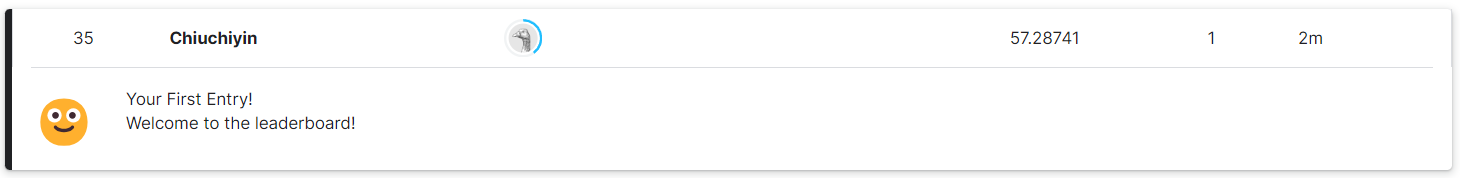

#### Train the model (Epoch = 100)

In [56]:
with strategy.scope():
    cycle_gan_model_100 = CycleGan(
        monet_generator, photo_generator, monet_discriminator, photo_discriminator
    )

    cycle_gan_model_100.compile(
        m_gen_optimizer = monet_generator_optimizer,
        p_gen_optimizer = photo_generator_optimizer,
        m_disc_optimizer = monet_discriminator_optimizer,
        p_disc_optimizer = photo_discriminator_optimizer,
        gen_loss_fn = generator_loss,
        disc_loss_fn = discriminator_loss,
        cycle_loss_fn = calc_cycle_loss,
        identity_loss_fn = identity_loss
    )

In [58]:
cycle_gan_model_100.fit(
    tf.data.Dataset.zip((monet_ds, photo_ds)),
    epochs=100
)

Epoch 1/100


2024-02-06 22:12:59.213311: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/sequential_8/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


300/300 [==============================] - 92s 238ms/step - monet_gen_loss: 2.8035 - photo_gen_loss: 3.2127 - monet_disc_loss: 0.5884 - photo_disc_loss: 0.4828
Epoch 2/100
300/300 [==============================] - 69s 229ms/step - monet_gen_loss: 2.8955 - photo_gen_loss: 3.3904 - monet_disc_loss: 0.5728 - photo_disc_loss: 0.4606
Epoch 3/100
300/300 [==============================] - 69s 230ms/step - monet_gen_loss: 2.8786 - photo_gen_loss: 3.3489 - monet_disc_loss: 0.5786 - photo_disc_loss: 0.4562
Epoch 4/100
300/300 [==============================] - 69s 231ms/step - monet_gen_loss: 2.8990 - photo_gen_loss: 3.4491 - monet_disc_loss: 0.5748 - photo_disc_loss: 0.4508
Epoch 5/100
300/300 [==============================] - 69s 231ms/step - monet_gen_loss: 2.8937 - photo_gen_loss: 3.3144 - monet_disc_loss: 0.5736 - photo_disc_loss: 0.4822
Epoch 6/100
300/300 [==============================] - 70s 233ms/step - monet_gen_loss: 2.9824 - photo_gen_loss: 3.3100 - monet_disc_loss: 0.5560 - phot

300/300 [==============================] - 68s 227ms/step - monet_gen_loss: 2.9587 - photo_gen_loss: 3.0365 - monet_disc_loss: 0.5902 - photo_disc_loss: 0.5677
Epoch 96/100
300/300 [==============================] - 69s 229ms/step - monet_gen_loss: 2.9722 - photo_gen_loss: 3.0983 - monet_disc_loss: 0.5754 - photo_disc_loss: 0.5551
Epoch 97/100
300/300 [==============================] - 69s 229ms/step - monet_gen_loss: 2.9523 - photo_gen_loss: 3.0558 - monet_disc_loss: 0.5742 - photo_disc_loss: 0.5669
Epoch 98/100
300/300 [==============================] - 69s 230ms/step - monet_gen_loss: 2.9187 - photo_gen_loss: 2.9948 - monet_disc_loss: 0.5878 - photo_disc_loss: 0.5740
Epoch 99/100
300/300 [==============================] - 69s 231ms/step - monet_gen_loss: 2.9299 - photo_gen_loss: 3.0013 - monet_disc_loss: 0.5921 - photo_disc_loss: 0.5691
Epoch 100/100
300/300 [==============================] - 68s 228ms/step - monet_gen_loss: 2.9094 - photo_gen_loss: 3.0062 - monet_disc_loss: 0.5857 

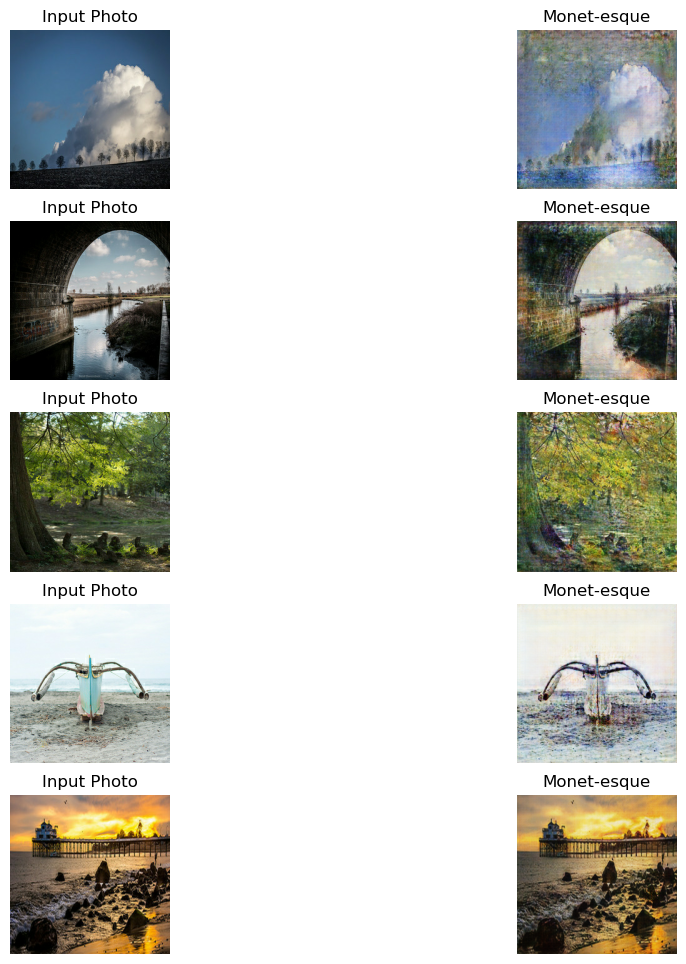

In [59]:
plot_image()

In [60]:
os.makedirs("images_100")
generate_images('./images_100/')
shutil.make_archive('100epoch', 'zip', './images_100/')

#### Train the model (Epoch = 400)

In [61]:
with strategy.scope():
    cycle_gan_model_400 = CycleGan(
        monet_generator, photo_generator, monet_discriminator, photo_discriminator
    )

    cycle_gan_model_400.compile(
        m_gen_optimizer = monet_generator_optimizer,
        p_gen_optimizer = photo_generator_optimizer,
        m_disc_optimizer = monet_discriminator_optimizer,
        p_disc_optimizer = photo_discriminator_optimizer,
        gen_loss_fn = generator_loss,
        disc_loss_fn = discriminator_loss,
        cycle_loss_fn = calc_cycle_loss,
        identity_loss_fn = identity_loss
    )

In [62]:
cycle_gan_model_400.fit(
    tf.data.Dataset.zip((monet_ds, photo_ds)),
    epochs=400
)

Epoch 1/400


2024-02-07 00:16:21.876556: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/sequential_8/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


300/300 [==============================] - 90s 239ms/step - monet_gen_loss: 2.9057 - photo_gen_loss: 2.9960 - monet_disc_loss: 0.5934 - photo_disc_loss: 0.5735
Epoch 2/400
300/300 [==============================] - 68s 228ms/step - monet_gen_loss: 2.9400 - photo_gen_loss: 3.0126 - monet_disc_loss: 0.5805 - photo_disc_loss: 0.5703
Epoch 3/400
300/300 [==============================] - 68s 228ms/step - monet_gen_loss: 2.9089 - photo_gen_loss: 2.9946 - monet_disc_loss: 0.5838 - photo_disc_loss: 0.5804
Epoch 4/400
300/300 [==============================] - 69s 229ms/step - monet_gen_loss: 2.9040 - photo_gen_loss: 2.9855 - monet_disc_loss: 0.5919 - photo_disc_loss: 0.5621
Epoch 5/400
300/300 [==============================] - 68s 227ms/step - monet_gen_loss: 2.8839 - photo_gen_loss: 2.9611 - monet_disc_loss: 0.5970 - photo_disc_loss: 0.5764
Epoch 6/400
300/300 [==============================] - 69s 229ms/step - monet_gen_loss: 2.8558 - photo_gen_loss: 2.9506 - monet_disc_loss: 0.5962 - phot

300/300 [==============================] - 69s 230ms/step - monet_gen_loss: 2.8127 - photo_gen_loss: 2.8825 - monet_disc_loss: 0.5812 - photo_disc_loss: 0.5790
Epoch 96/400
300/300 [==============================] - 68s 228ms/step - monet_gen_loss: 2.9224 - photo_gen_loss: 2.8943 - monet_disc_loss: 0.5487 - photo_disc_loss: 0.5686
Epoch 97/400
300/300 [==============================] - 68s 228ms/step - monet_gen_loss: 2.8557 - photo_gen_loss: 2.8933 - monet_disc_loss: 0.5726 - photo_disc_loss: 0.5703
Epoch 98/400
300/300 [==============================] - 69s 231ms/step - monet_gen_loss: 2.9693 - photo_gen_loss: 2.8906 - monet_disc_loss: 0.5352 - photo_disc_loss: 0.5802
Epoch 99/400
300/300 [==============================] - 69s 230ms/step - monet_gen_loss: 2.9049 - photo_gen_loss: 2.8771 - monet_disc_loss: 0.5581 - photo_disc_loss: 0.5811
Epoch 100/400
300/300 [==============================] - 70s 232ms/step - monet_gen_loss: 3.0443 - photo_gen_loss: 2.9005 - monet_disc_loss: 0.5074 

300/300 [==============================] - 69s 231ms/step - monet_gen_loss: 3.0988 - photo_gen_loss: 2.9636 - monet_disc_loss: 0.5499 - photo_disc_loss: 0.5500
Epoch 190/400
300/300 [==============================] - 69s 231ms/step - monet_gen_loss: 3.1821 - photo_gen_loss: 2.9761 - monet_disc_loss: 0.5043 - photo_disc_loss: 0.5641
Epoch 191/400
300/300 [==============================] - 70s 232ms/step - monet_gen_loss: 3.1021 - photo_gen_loss: 2.9785 - monet_disc_loss: 0.5920 - photo_disc_loss: 0.5525
Epoch 192/400
300/300 [==============================] - 69s 231ms/step - monet_gen_loss: 3.1897 - photo_gen_loss: 2.9703 - monet_disc_loss: 0.4976 - photo_disc_loss: 0.5521
Epoch 193/400
300/300 [==============================] - 69s 230ms/step - monet_gen_loss: 3.2059 - photo_gen_loss: 2.9889 - monet_disc_loss: 0.4976 - photo_disc_loss: 0.5640
Epoch 194/400
300/300 [==============================] - 70s 232ms/step - monet_gen_loss: 3.2511 - photo_gen_loss: 2.9692 - monet_disc_loss: 0.4

300/300 [==============================] - 70s 232ms/step - monet_gen_loss: 3.4150 - photo_gen_loss: 3.0655 - monet_disc_loss: 0.4688 - photo_disc_loss: 0.5626
Epoch 284/400
300/300 [==============================] - 68s 228ms/step - monet_gen_loss: 3.3459 - photo_gen_loss: 3.0507 - monet_disc_loss: 0.4990 - photo_disc_loss: 0.5501
Epoch 285/400
300/300 [==============================] - 68s 226ms/step - monet_gen_loss: 3.4064 - photo_gen_loss: 3.0305 - monet_disc_loss: 0.4626 - photo_disc_loss: 0.5486
Epoch 286/400
300/300 [==============================] - 69s 229ms/step - monet_gen_loss: 3.3042 - photo_gen_loss: 3.0373 - monet_disc_loss: 0.5142 - photo_disc_loss: 0.5531
Epoch 287/400
300/300 [==============================] - 69s 229ms/step - monet_gen_loss: 3.4008 - photo_gen_loss: 3.0302 - monet_disc_loss: 0.4802 - photo_disc_loss: 0.5378
Epoch 288/400
300/300 [==============================] - 69s 229ms/step - monet_gen_loss: 3.3536 - photo_gen_loss: 3.0560 - monet_disc_loss: 0.5

300/300 [==============================] - 68s 227ms/step - monet_gen_loss: 3.6041 - photo_gen_loss: 3.1043 - monet_disc_loss: 0.4281 - photo_disc_loss: 0.5464
Epoch 378/400
300/300 [==============================] - 69s 231ms/step - monet_gen_loss: 3.6203 - photo_gen_loss: 3.0962 - monet_disc_loss: 0.4221 - photo_disc_loss: 0.5404
Epoch 379/400
300/300 [==============================] - 70s 232ms/step - monet_gen_loss: 3.5714 - photo_gen_loss: 3.0897 - monet_disc_loss: 0.4703 - photo_disc_loss: 0.5407
Epoch 380/400
300/300 [==============================] - 69s 230ms/step - monet_gen_loss: 3.4371 - photo_gen_loss: 3.0910 - monet_disc_loss: 0.5241 - photo_disc_loss: 0.5397
Epoch 381/400
300/300 [==============================] - 69s 229ms/step - monet_gen_loss: 3.4651 - photo_gen_loss: 3.1126 - monet_disc_loss: 0.4514 - photo_disc_loss: 0.5375
Epoch 382/400
300/300 [==============================] - 70s 232ms/step - monet_gen_loss: 3.5789 - photo_gen_loss: 3.1121 - monet_disc_loss: 0.4

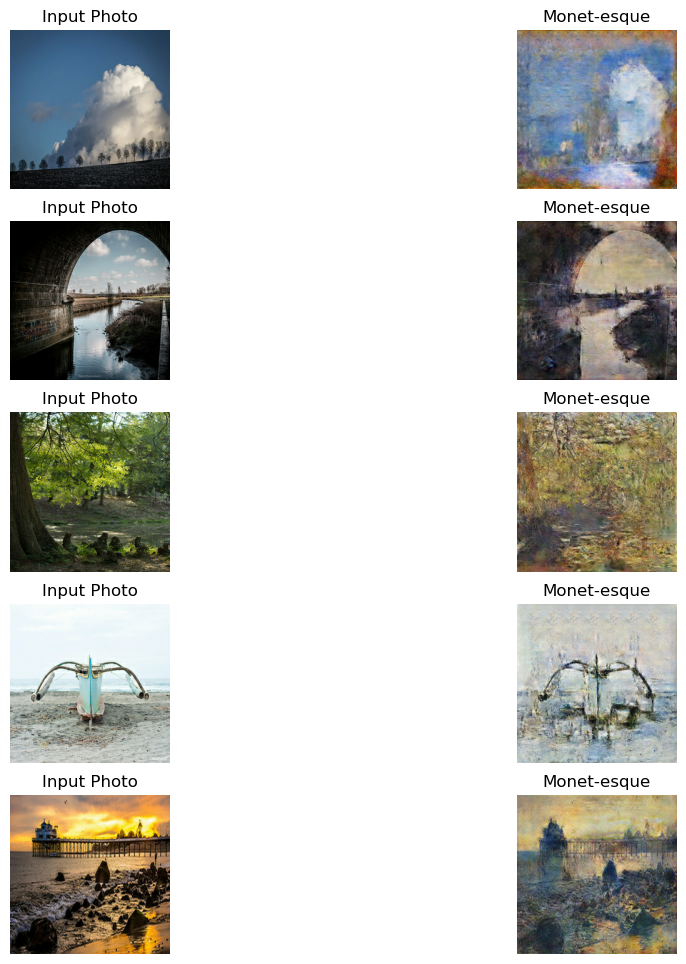

In [63]:
plot_image()

In [64]:
os.makedirs("images_400")
generate_images('./images_400/')
shutil.make_archive('400epoch', 'zip', './images_400/')

'/mnt/e/I-m-Something-of-a-Painter-Myself/50epoch.zip'